In [1]:
from infer import * 
from create_input import *

import numpy as np
import matplotlib.pyplot as plt

/home/daniel/miniconda3/envs/satlas/lib/python3.11/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [2]:
PATH = "/media/daniel/data1/sentinel2/Wallonia_for_SatlasSR/spring_2018/sentinel_images"

N_S2_IMAGES = 6 
PATCH_OFFSET = 8
PATCH_SIZE = 32
weights_path = "./weights/esrgan_orig_6S2.pth"
device = 'cuda'
model: RRDBNet = load_model(weights_path, device, N_S2_IMAGES)

In [3]:
images = load_series(PATH,0, N_S2_IMAGES)
patches_iter = get_patches(images, PATCH_OFFSET, PATCH_SIZE)
patches = list(patches_iter)

In [16]:
def create_batch_patches(images, patch_size, offset, grid=4):
    dx = patch_size - offset
    dy = patch_size - offset

    off2 = offset//2

    size = 512 // grid
    X = 0 * size
    Y = 0 * size
    
    patches = []
    for i, x in enumerate(range(X-off2, X+size-off2, dx)):
        for j, y in enumerate(range(Y-off2, Y+size-off2, dy)):
            tile = []
            for img in images:
                one_tile = np.zeros((patch_size, patch_size, 3))
                x = max(0, x)
                y = max(0, y)
                data = img[x:x+patch_size, y:y+patch_size]
                one_tile[:data.shape[0], :data.shape[1]] = data
                tile.append(one_tile)
            
            patches.append(((i,j), np.concatenate(tile)))
    return patches

def stitch_batch_patches(patches, patch_size, offset, grid=4):

    
    dx = patch_size - offset
    dy = patch_size - offset

    off2 = offset//2

    size = 512 // grid
    X = 0 * size
    Y = 0 * size
    
    res = np.zeros((size*4, size*4, 3))

    mask = np.zeros((patch_size*4, patch_size*4, 3))
    mask[off2*4:-off2*4, off2*4:-off2*4] = 1
    
    for i, x in enumerate(range(-off2, size-off2, dx)):
        for j, y in enumerate(range(-off2, size-off2, dy)):

            x1 = max(0, x) * 4
            y1 = max(0, y) * 4
            x2 = min(x+patch_size, size) * 4
            y2 = min(y+patch_size, size) * 4

            px = x1 - x*4
            py = y1 - y*4
            
            p = patches[(i,j)] * mask
            # print(i,j, x*4,y*4, x1, x2, y1, y2, p.shape)


            res[x1:x2, y1:y2] += p[px:px+x2-x1,py:py+y2-y1]
            # plt.imshow(res / 255)
            # plt.show()

    return res
    
    

In [5]:
batch_patches = create_batch_patches(images, PATCH_SIZE, PATCH_OFFSET, grid=4)
print(len(batch_patches))

36


In [6]:
input_size = 512
output_size = 2048
X = 0
X_start = X * input_size
X_end = X_start + input_size
Y = 0
Y_start = Y * input_size
Y_end = Y_start + input_size

ps = 32 * 4
offset = 8 * 4 // 2

data = []
for (i, j), d in patches:
    x1 = i * (ps - offset)
    x2 = x1 + ps

    y1 = j * (ps - offset)
    y2 = y1 + ps
    
    if (X_start <= x1 < X_end or X_start < x2 < X_end) and\
        (Y_start <= y1 < Y_end or Y_start <= y2 < Y_end):
        data.append(((i,j), d))

In [7]:
def get_good_patches(data, n_s2_images=6):
    data = np.reshape(data, (-1, 32, 32, 3))
    # Iterate through the 32x32 chunks at each timestep, separating them into "good" (valid)
    # and "bad" (partially black, invalid). Will use these to pick best collection of S2 images.
    goods, bads = [], []
    for i,ts in enumerate(data):
        if [0, 0, 0] in ts:
            bads.append(i)
        else:
            goods.append(i)

    # Pick {n_s2_images} random indices of s2 images to use. Skip ones that are partially black.
    if len(goods) >= n_s2_images:
        rand_indices = random.sample(goods, n_s2_images)
    else:
        need = n_s2_images - len(goods)
        rand_indices = goods + random.sample(bads, need)

    data = [data[i] for i in rand_indices]
    data = np.array(data)

    # Convert to torch tensor.
    res = [totensor(img) for img in data]

    return res
    
def infer_batch(s2_data, n_s2_images, model, device) :
    # Reshape to be Tx32x32x3.
    all_images = []

    for d in s2_data:
        all_images.extend(get_good_patches(d))

    s2_tensor = torch.cat(all_images).unsqueeze(0).to(device)
    s2_tensor = s2_tensor.reshape(-1, n_s2_images * 3, 32, 32).float()
    print(s2_tensor.shape)

    # Feed input of shape [batch, n_s2_images * channels, 32, 32] through model.
    output = model(s2_tensor)
    # output = s2_tensor.detach().cpu().numpy()
    return output

In [19]:
images = [x[1] /255 for x in batch_patches]
o =infer_batch(images, 6, model, device)
o = o.detach().cpu().numpy()
o = o.transpose(0,2,3,1)
# o = o- np.min(o)
# o = o / np.max(o)
o[o<0] = 0
o[o>1] = 1
o = o * 255
o = o.astype(np.uint8)
sr_patches = {k[0]: v for k, v in zip(batch_patches, o)}

torch.Size([36, 18, 32, 32])


In [21]:
res = stitch_batch_patches(sr_patches, 32, 8, 4)
# plt.imshow(res/255)
plt.imsave("res.png", res/255)

In [132]:
o = o.detach().cpu().numpy()
o = o.transpose(0, 2, 3, 1)
o.shape

(25, 128, 128, 3)

(32, 32, 3)

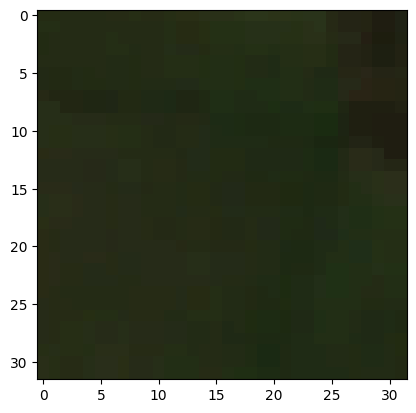

In [62]:
d1 = o[0].reshape(6, 3, 32, 32)[3].transpose(1,2,0)
plt.imshow(d1 / 105)
d1.shape

(128, 128, 3)
0.5220428 0.0


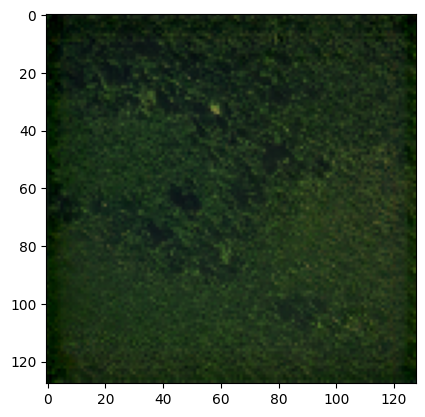

In [135]:
oo = o[2]
print(oo.shape)
oo[oo < 0] = 0
oo[oo > 1] = 1
print(np.max(oo), np.min(oo))
plt.imshow(oo )

In [127]:
srp = sr_image(patches[0][1],6, model, device)

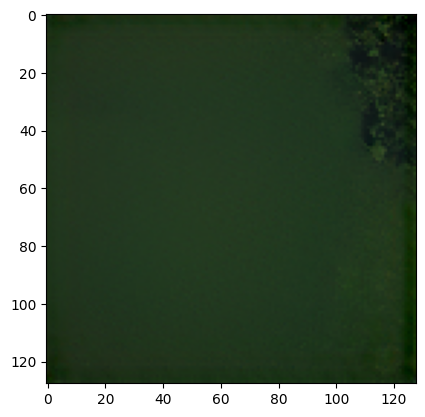

In [ ]:
def stitch_batch(patches: List[Patch] | Iterator[Patch],
           scale: int=4,
           offset: int=10,
           src_image_size: int=512,
           patch_size: int=32) -> np.ndarray:

    img_size = src_image_size * scale
    chunk_size = patch_size * scale
    n_images = math.ceil((src_image_size) / (patch_size - offset))
    target_offset = offset * scale

    result = np.zeros((512, 512, 3))

    margin = target_offset // 2
    # mask
    X = 0
    X_start = X * input_size
    X_end = X_start + input_size
    Y = 0
    Y_start = Y * input_size
    Y_end = Y_start + input_size 

    for (i,j), img in patches:

        dx = (patch_size - offset) * scale
        x = i * dx
        y = j * dx

        x_size = min(i*dx + chunk_size, img_size) - i*dx
        y_size = min(j*dx + chunk_size, img_size) - j*dx

        result[i*dx:min(i*dx + chunk_size, img_size), j*dx:min(j*dx+chunk_size, img_size), :] += img[:x_size, :y_size, :]

    return result

In [1]:
import tifffile

In [24]:
IDX = 110
label = tifffile.imread(f"/media/daniel/data1/sentinel2/Wallonia_for_SatlasSR/labels/resolution_10_size_512/mask_{IDX}.tif")
img = tifffile.imread(f"/media/daniel/data1/sentinel2/2021_seasons/Belgium_autumn2021/images/Belgium_image_tile_{IDX+1:04}.tif")

img = img.transpose(1,2,0)
img = img[:, :, [3,2,1]]
img = img / 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


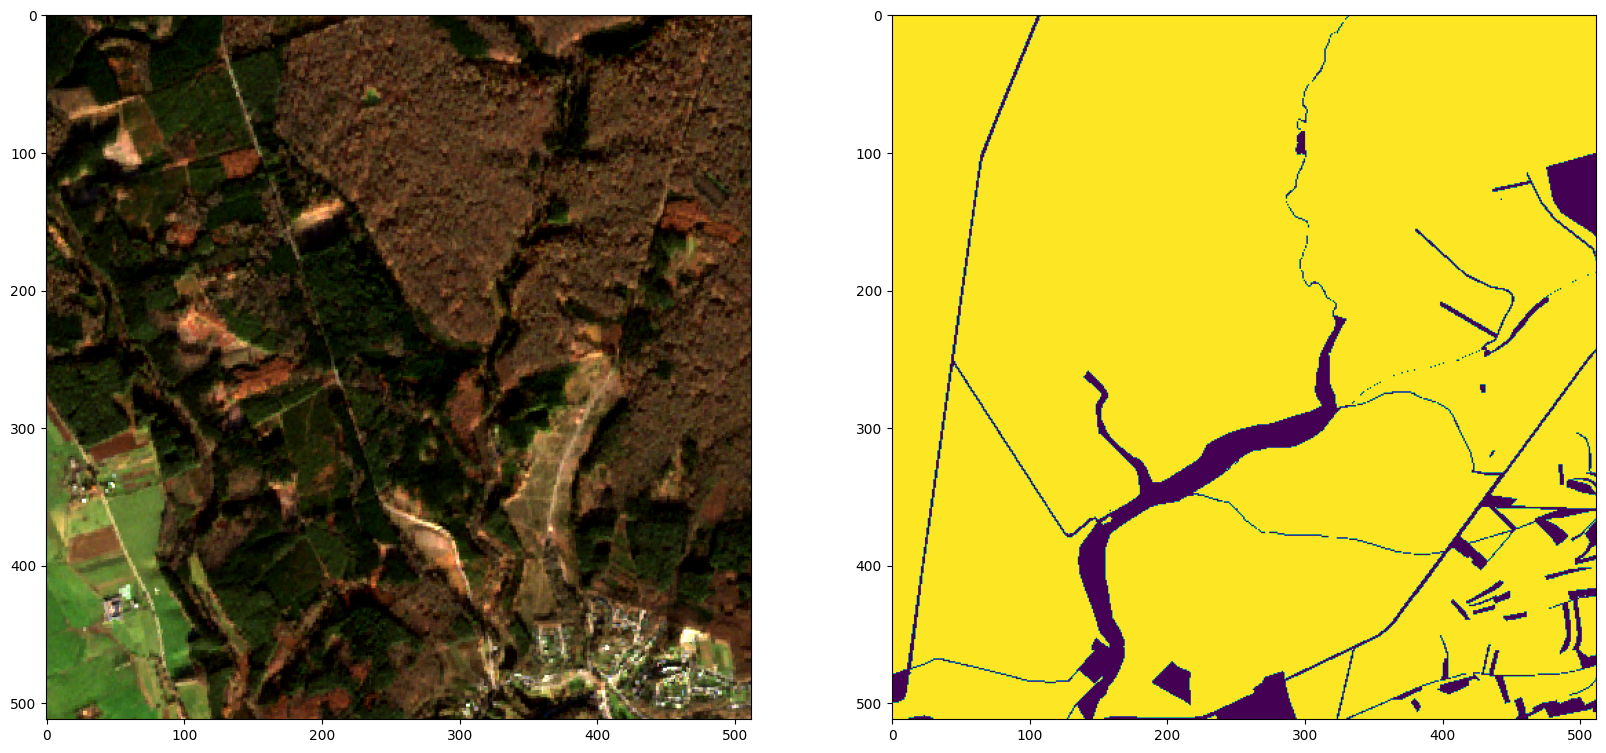

In [25]:
import matplotlib.pyplot as plt
# plot two images next to each other
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax1.imshow(img)
ax2 = fig.add_subplot(122)
ax2.imshow(label)

In [1]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np

In [4]:
IDX = 2
x, y = 0,0
LR_PATH = f'/media/daniel/data3/sentinel2/Wallonie/Wallonie_spring_2018/images_128/Wallonie_image_tile_{IDX:04d}_{x}_{y}.tif'
HR_PATH = f'/media/daniel/data3/sentinel2/Wallonie_SatlasSR/spring_2018/sr_images/{IDX}_{x}_{y}.tif'
LABEL_PATH = f'/media/daniel/data3/sentinel2/Wallonie_SatlasSR/labels/resolution_2.5_size_512/{IDX}_{x}_{y}.tif'

In [8]:
# lr = tifffile.imread(LR_PATH)
hr = tifffile.imread(HR_PATH)
# label = tifffile.imread(LABEL_PATH)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


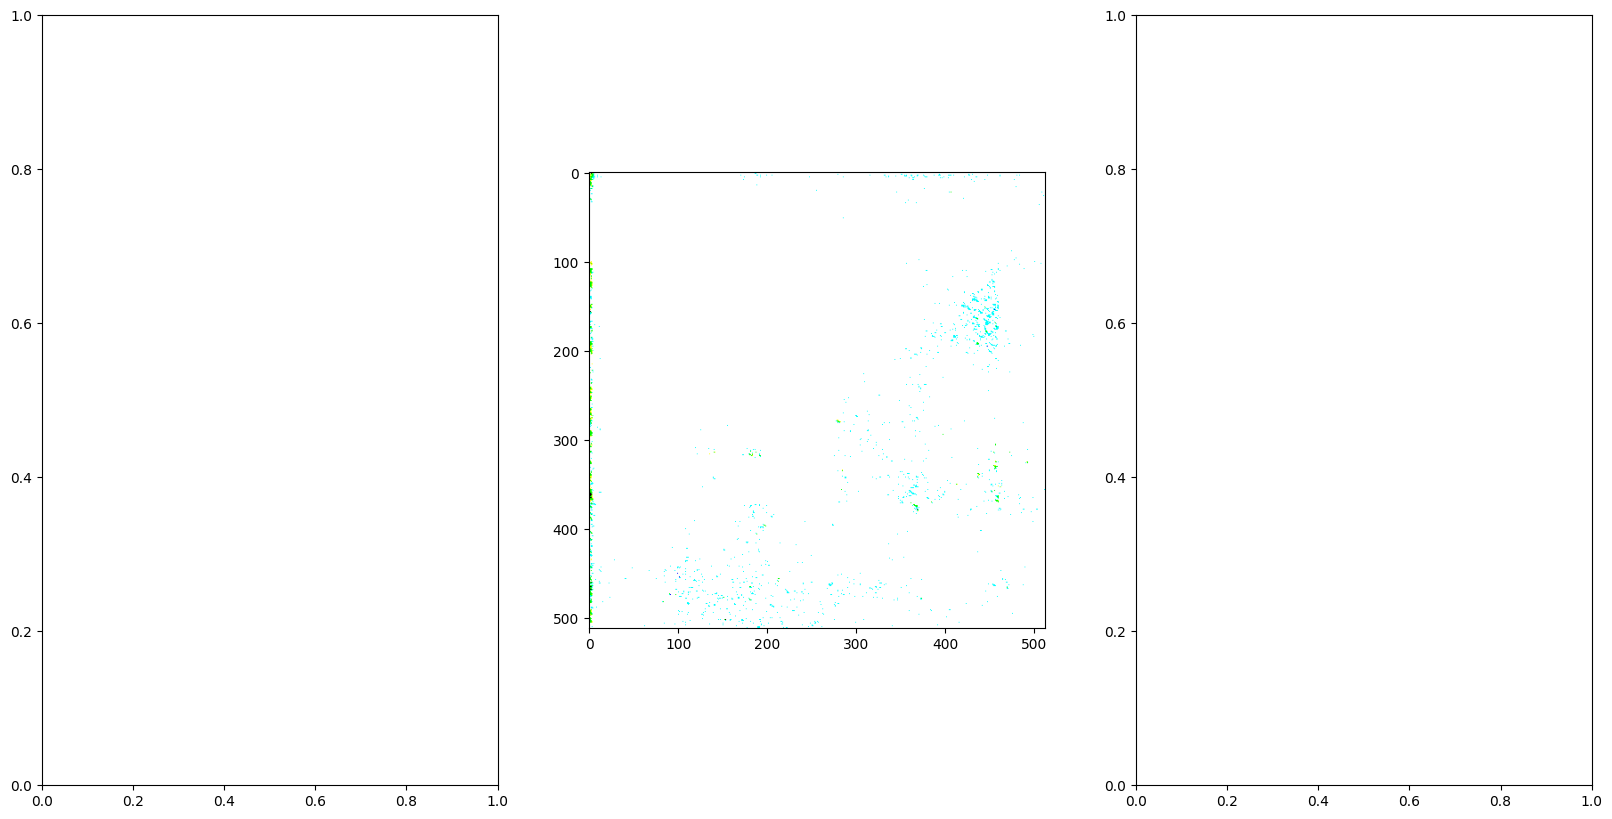

In [9]:


from matplotlib import cm


hr = hr.transpose(1,2,0) / 255
print(hr.shape)
# lr = lr.transpose(1,2,0)[:,:,[3,2,1]] / 10_000 * 3
# label = label / 10 

fig, axs = plt.subplots(1,3, figsize=(20, 10))
# plt.axis('off')
# axs[0].imshow(lr)
axs[1].imshow(hr)
# axs[2].imshow(label,cmap='gray')

# plt.imsave("lr.png", lr)
# plt.imsave("hr.png", hr)
# plt.imsave("label.png", label, cmap='gray')